#Problème n°1

La bonne transmission de signaux électromagnétiques dans l'atmosphère peut dépendre de la météo. La pluie affecte notoirement les échanges entre les antennes relais des réseaux mobiles actuels. C'est une gêne, mais aussi une opportunité: l'atténuation des ondes électromagnétiques due à la pluie peut être mesurée et utilisée comme un moyen de quantifier les précipitations.

Dans ce problème, on s'intéresse à la conversion de l'atténuation, définie comme un rapport entre puissance émise et puissance reçue et exprimée en dB, en un taux de pluie moyen le long de segments physiques dont les extrémités sont des paires d'antennes relais.

Evidemment, d'autres éléments que le pluie, plus ou moins bien connus, peuvent influencer l'atténuation. La simulation sur laquelle nous allons travailler, qui porte sur un millier de paires d'antennes virtuelles, est construite de la façon suivante:

- pour une paire d'antennes donnée, on modélise une série temporelle de taux de pluie moyen par un processus stochastique dont les paramètres dépendent entre autres de la distance qui sépare les antennes.
- pour en tirer des atténuations, on applique à cette série les transformations suivantes:
    - un filtre convolutif, censé modéliser l'impact du film d'eau se formant sur les antennes au cours d'un épisode de pluie.
    - une conversion non-linéaire, tirée d'un modèle physique, est appliquée composante à composante.
 épisode pluvieux (ce film qui s'épaissit augmente progressivement l'atténuation).
    - un bruit haute-fréquence
    - un bruit basse fréquence

La cellules suivantes permettent de récupérer les briques de code utiles, de construire un dictionnaire contenant des identifiants de paires d'antennes (clefs) et les distances les séparant (valeurs). La dernière cellule montre des exemples de séries temporelles simulées pour quelques paires.

In [56]:
# Local clone
! git clone https://github.com/0Yassine0/exam_2025.git
! cp exam_2025/utils/utils_probleme1.py .

fatal: destination path 'exam_2025' already exists and is not an empty directory.


In [89]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np
import sys
from utils_probleme1 import create_dataloader

In [90]:
# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création du dataloader (il contient toutes les étapes de la simulation)
# (en une époque, chaque paire d'antennes du dictionnaire idx2distance
# a été tirée exactement une fois)
trainloader = create_dataloader(duration, idx2distance_train, batch_size)

# Génération d'un batch contenant des séries temporelles
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
    break

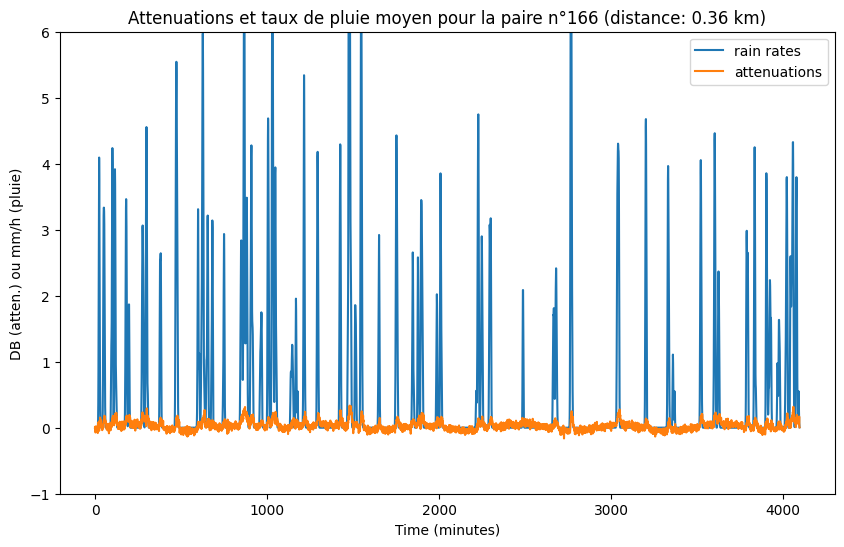

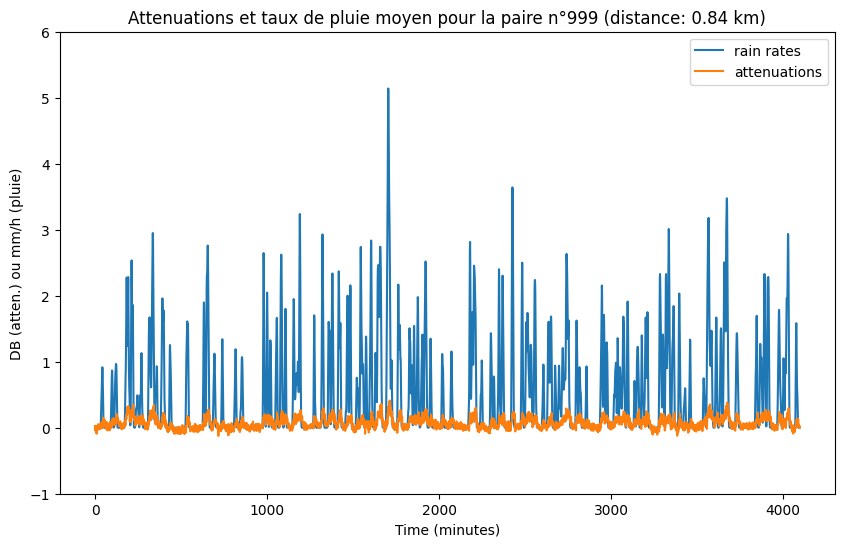

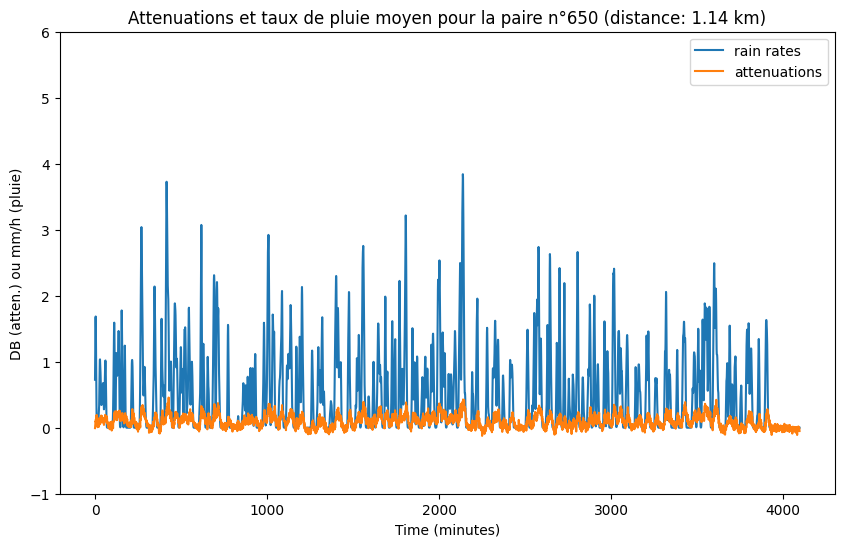

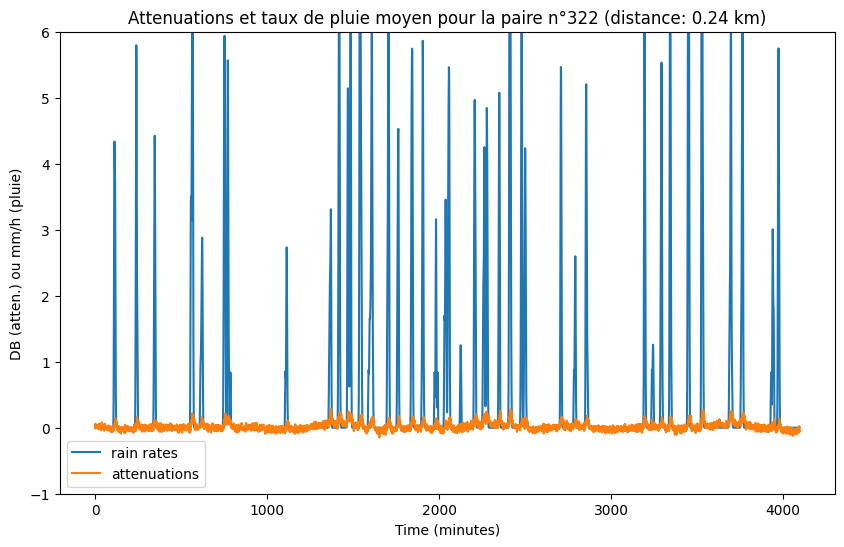

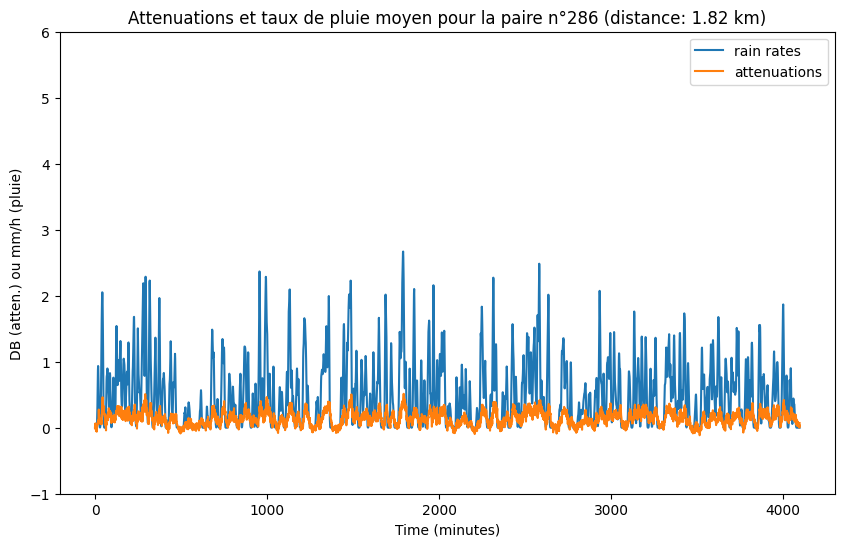

In [91]:
import matplotlib.pyplot as plt

for k in range(5):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), rain_rates[k], label='rain rates')
  plt.plot(np.arange(duration), attenuations[k], label='attenuations')
  plt.title(f"Attenuations et taux de pluie moyen pour la paire n°{ids[k].item():.0f} (distance: {dists[k].item():.2f} km)")
  plt.xlabel('Time (minutes)')
  plt.ylabel('DB (atten.) ou mm/h (pluie)')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

## Partie I : Un réseau de neurones générique

# A partir des briques de base

Dans cette partie, on entraîne un UNet1D à faire le lien entre atténuations
et taux de pluie. Les cellules suivantes contiennent les blocs du UNet1D et son montage :

In [92]:
##############################################################################################
################################     UNet 1D building blokcs    ##############################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2)))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


################################################################################
######################################## class UNet1D ##########################

class UNet1D(nn.Module):
    def __init__(self, n_channels, n_classes, size=64):
        super(UNet1D, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x

**Consignes:** \
1) Entraîner sur GPU un UNet 1D à restituer les taux de pluie à partir des atténuations.
- On utilisera la MSE comme fonction de coût et comme score. Dans les deux cas, prendre une marge de deux heures au début et à la fin de la série temporelle pour éviter les effets de bord.
- La descente de gradient stochastique sera pilotée par l'optimiseur ADAM (paramétrage standard) sur cinquante époques.

2) Tracer la courbe d'apprentissage de manière à montrer l'évolution:
- des performances en généralisation sur de nouvelles données issues des paires d'antennes vues à l'entraînement.
- des performances en généralisation sur des séries issues de paires d'antennes indépendantes (celles de *idx2distance_val*).


3) Visualiser les prédictions après apprentissage

In [97]:
n_channels = 1
n_classes = 1
model = UNet1D(n_channels, n_classes, size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [99]:
valloader = create_dataloader(duration, idx2distance_val, batch_size)

Epoch 1/50:
Train Loss: 0.219413
Val Loss: 0.793055
Epoch 2/50:
Train Loss: 0.165443
Val Loss: 0.616782
Epoch 3/50:
Train Loss: 0.155001
Val Loss: 0.364746
Epoch 4/50:
Train Loss: 0.151865
Val Loss: 0.168952
Epoch 5/50:
Train Loss: 0.148817
Val Loss: 0.156927
Epoch 6/50:
Train Loss: 0.144539
Val Loss: 0.136051
Epoch 7/50:
Train Loss: 0.143121
Val Loss: 0.146995
Epoch 8/50:
Train Loss: 0.140120
Val Loss: 0.136261
Epoch 9/50:
Train Loss: 0.141113
Val Loss: 0.135520
Epoch 10/50:
Train Loss: 0.139168
Val Loss: 0.131725
Epoch 11/50:
Train Loss: 0.137475
Val Loss: 0.146693
Epoch 12/50:
Train Loss: 0.139685
Val Loss: 0.133814
Epoch 13/50:
Train Loss: 0.139003
Val Loss: 0.131502
Epoch 14/50:
Train Loss: 0.141018
Val Loss: 0.131527
Epoch 15/50:
Train Loss: 0.138315
Val Loss: 0.130646
Epoch 16/50:
Train Loss: 0.134983
Val Loss: 0.132352
Epoch 17/50:
Train Loss: 0.133037
Val Loss: 0.133143
Epoch 18/50:
Train Loss: 0.135638
Val Loss: 0.132068
Epoch 19/50:
Train Loss: 0.131342
Val Loss: 0.124764
Ep

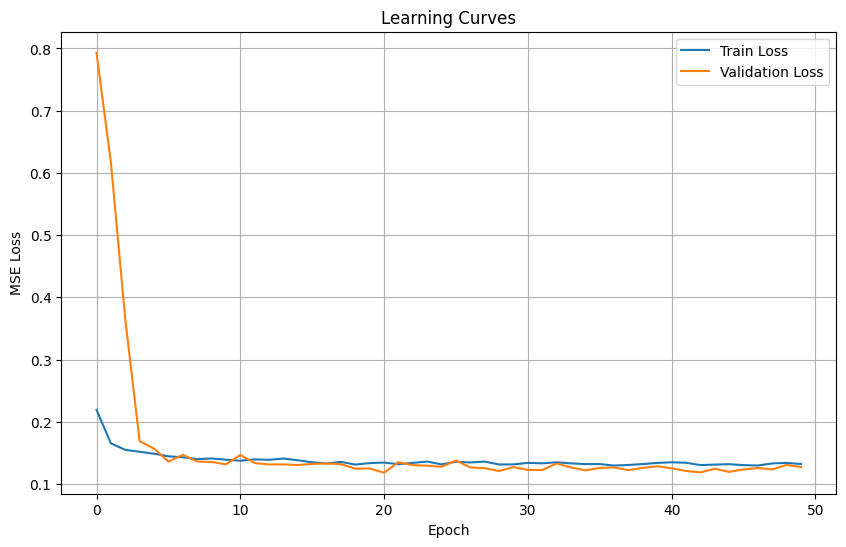

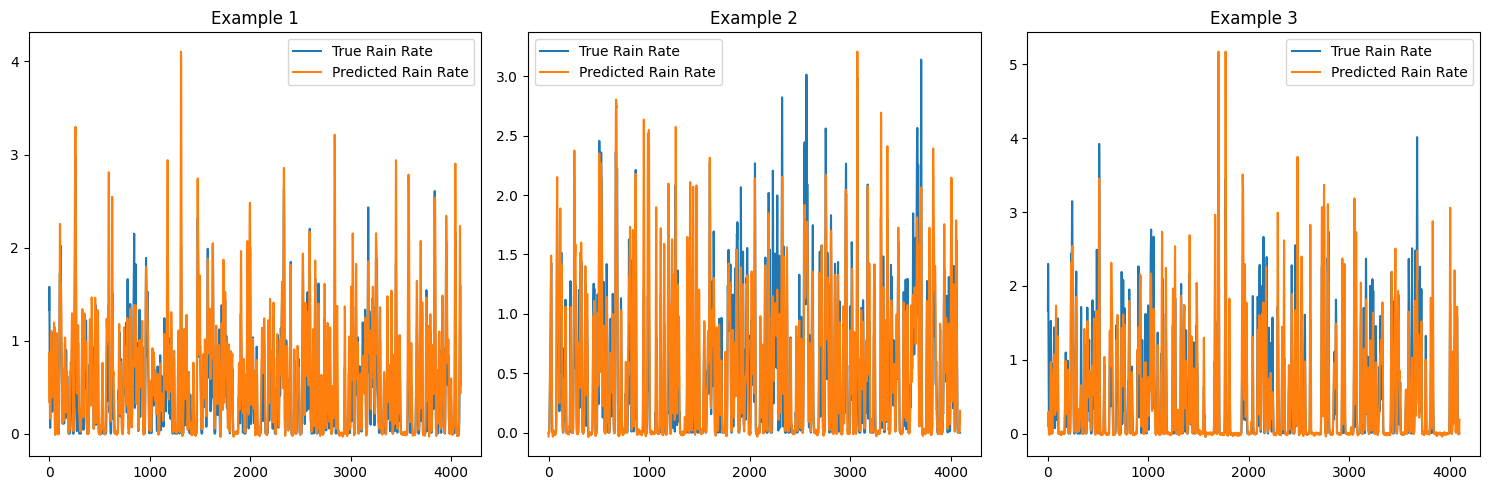

In [102]:
train_losses = []
val_losses = []
n_epochs = 50
margin = 120

# Boucle d'entraînement
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    batch_count = 0

    # Entraînement
    for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
        optimizer.zero_grad()

        attenuations = attenuations.to(device)  # Ajout dimension des channels
        rain_rates = rain_rates.to(device)

        outputs = model(attenuations.unsqueeze(1))
        loss = criterion(outputs[:, 0, margin:-margin], rain_rates[:, margin:-margin])

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1

    train_losses.append(epoch_loss / len(trainloader))

    # Validation sur nouvelles paires
    model.eval()
    val_loss = 0.0
    batch_count = 0

    with torch.no_grad():
        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
            attenuations = attenuations.unsqueeze(1).to(device)
            rain_rates = rain_rates.to(device)

            outputs = model(attenuations)
            loss = criterion(outputs[:, 0, margin:-margin], rain_rates[:, margin:-margin])

            val_loss += loss.item()
            batch_count += 1

    val_losses.append(val_loss / len(valloader))

    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'Train Loss: {train_losses[-1]:.6f}')
    print(f'Val Loss: {val_losses[-1]:.6f}')

# Visualisation des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

# Visualisation des prédictions
model.eval()
with torch.no_grad():
    # Prendre un exemple du validation set
    for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
        attenuations = attenuations.unsqueeze(1).to(device)
        rain_rates = rain_rates.unsqueeze(1).to(device)

        outputs = model(attenuations)

        # Visualiser quelques exemples
        plt.figure(figsize=(15, 5))
        for i in range(3):  # Visualiser 3 exemples
            plt.subplot(1, 3, i+1)
            plt.plot(rain_rates[i, 0].cpu().numpy(), label='True Rain Rate')
            plt.plot(outputs[i, 0].cpu().numpy(), label='Predicted Rain Rate')
            plt.title(f'Example {i+1}')
            plt.legend()
        plt.tight_layout()
        plt.show()
        break

## Partie II

Dans la première partie, le modèle était générique: la specificité de la paire d'antenne n'était pas prise en compte. On se propose de le faire en combinant un réseau générique à un perceptron spécifique, de sorte que la sortie $Z$ s'exprime sous la forme: \
$$Z = F(X, k) = f^{\tiny{Perceptron}}_{\alpha_k}(f^{\tiny{UNet}}_{\theta}(X))$$ \
 où $f^{\tiny{UNet}}_{\theta}(.)$ représente la fonction *forward* d'un UNet et $f^{\tiny{Perceptron}}_{\alpha_k}(.)$, la fonction forward du perceptron associé à la paire d'antennes d'identifiant $k$. \

Il s'agit donc en premier lieu d'adjoindre au UNet de la partie I autant de perceptrons que le jeu d'entraînement compte de paires d'antennes, ce qui se fait grâce aux lignes suivantes:

In [ ]:
# Pour l'ajout de 1200 perceptrons à deux couches:
self.num_pairs = 1200
self.input_size_fc_layer = 5
self.hidden_size_fc_layer = 5
# Liste des premières couches
self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                         self.hidden_size_fc_layer) for i in range(self.num_pairs)])
# Liste des secondes couches
self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                         1) for i in range(self.num_pairs)])


**Consignes:** \
1) Définir une nouvelle classe de réseau en modifiant la classe UNet1D (dans utils_probleme1.py).
Ajouter ces perceptrons au réseau.

2) Fixer *self.n_classes* de façon à ce que la sortie du UNet soit compatible avec l'entrée du perceptron.

3) Modifications de la fonction forward:
- elle doit prendre comme arguments un batch d'entrées et un batch d'identifiants.

- après les étapes propres au UNet, elle doit appliquer le perceptron d'indice k à une série provenant de la paire n°k. La cellule de code suivante fournit un exemple dont on pourra directement s'inspirer.

4) Suivre les performances en généralisation sur les paires d'antennes du jeu d'entraînement et sur les deux cents paires de validation. Commenter.




Epoch 1/50:
Train Loss: 0.559149
Val Loss: 0.764835
Epoch 2/50:
Train Loss: 0.261270
Val Loss: 0.577413
Epoch 3/50:
Train Loss: 0.234978
Val Loss: 0.282455
Epoch 4/50:
Train Loss: 0.225416
Val Loss: 0.278777
Epoch 5/50:
Train Loss: 0.215948
Val Loss: 0.265953
Epoch 6/50:
Train Loss: 0.214065
Val Loss: 0.228459
Epoch 7/50:
Train Loss: 0.212560
Val Loss: 0.204045
Epoch 8/50:
Train Loss: 0.209125
Val Loss: 0.205232
Epoch 9/50:
Train Loss: 0.205204
Val Loss: 0.218733
Epoch 10/50:
Train Loss: 0.199902
Val Loss: 0.210066
Epoch 11/50:
Train Loss: 0.201228
Val Loss: 0.211137
Epoch 12/50:
Train Loss: 0.202223
Val Loss: 0.213846
Epoch 13/50:
Train Loss: 0.198267
Val Loss: 0.213432
Epoch 14/50:
Train Loss: 0.194184
Val Loss: 0.236991
Epoch 15/50:
Train Loss: 0.192554
Val Loss: 0.214944
Epoch 16/50:
Train Loss: 0.192047
Val Loss: 0.203846
Epoch 17/50:
Train Loss: 0.188835
Val Loss: 0.208134
Epoch 18/50:
Train Loss: 0.189996
Val Loss: 0.201868
Epoch 19/50:
Train Loss: 0.184379
Val Loss: 0.202041
Ep

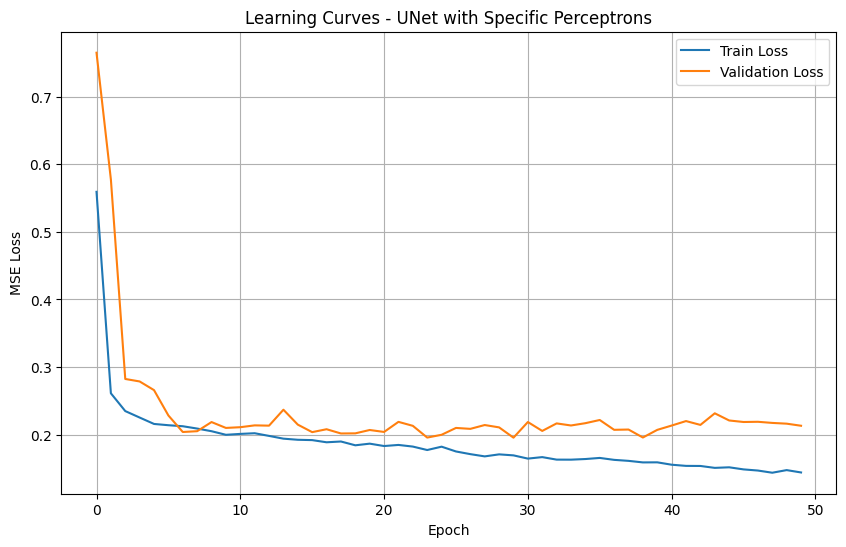

In [103]:
class UNet1DWithPerceptrons(nn.Module):

    def apply_perceptron(self, UNet_output, ids):
      for i in range(ids.shape[0]):
          id = ids[i]
          # application de la première couche
          x = self.linears1[id](UNet_output[i].transpose(0,1).contiguous())
          x = self.relu(x)
          # application de la seconde couche
          x = self.linears2[id](x)
          # correction multiplicative de UNet_output
          UNet_output[i, 0:1, :] *= 1 + x.transpose(0, 1).contiguous()
      return UNet_output[:,0]

    def __init__(self, n_channels, size=64):
        super(UNet1DWithPerceptrons, self).__init__()
        # UNet components
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)

        # Set n_classes to match perceptron input size
        self.n_classes = 5  # Correspond à input_size_fc_layer
        self.outc = outconv(size, self.n_classes)

        # Perceptron components
        self.num_pairs = 1200
        self.input_size_fc_layer = 5
        self.hidden_size_fc_layer = 5

        # Liste des premières couches
        self.linears1 = nn.ModuleList([
            nn.Linear(self.input_size_fc_layer, self.hidden_size_fc_layer)
            for i in range(self.num_pairs)
        ])

        # Liste des secondes couches
        self.linears2 = nn.ModuleList([
            nn.Linear(self.hidden_size_fc_layer, 1)
            for i in range(self.num_pairs)
        ])

        self.relu = nn.ReLU()

    def forward(self, x, ids):
        # UNet forward pass
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)

        # Apply perceptrons
        return self.apply_perceptron(x, ids)

def train_and_evaluate(model, trainloader, valloader, n_epochs, device, margin=120):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # Training
        model.train()
        epoch_loss = 0.0
        batch_count = 0

        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
            optimizer.zero_grad()

            ids = ids.to(device)
            attenuations = attenuations.unsqueeze(1).to(device)
            rain_rates = rain_rates.to(device)

            outputs = model(attenuations, ids)
            loss = criterion(outputs[:, margin:-margin], rain_rates[:, margin:-margin])

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        train_losses.append(epoch_loss / batch_count)

        # Validation on training pairs
        model.eval()
        val_loss = 0.0
        batch_count = 0

        with torch.no_grad():
            for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
                ids = ids.to(device)
                attenuations = attenuations.unsqueeze(1).to(device)
                rain_rates = rain_rates.to(device)

                outputs = model(attenuations, ids)
                loss = criterion(outputs[:, margin:-margin], rain_rates[:, margin:-margin])

                val_loss += loss.item()
                batch_count += 1

        val_losses.append(val_loss / batch_count)

        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Train Loss: {train_losses[-1]:.6f}')
        print(f'Val Loss: {val_losses[-1]:.6f}')

    return train_losses, val_losses


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet1DWithPerceptrons(n_channels=1).to(device)

trainloader = create_dataloader(duration, idx2distance_train, batch_size)
valloader = create_dataloader(duration, idx2distance_val, batch_size)

train_losses, val_losses = train_and_evaluate(
    model, trainloader, valloader, n_epochs=50, device=device
)


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curves - UNet with Specific Perceptrons')
plt.legend()
plt.grid(True)
plt.show()


## Partie III

La solution proposée dans la partie II a un défaut: les performances chutent sur les paires d'antennes qui n'ont pas été rencontrées pendant l'entraînement. Pour le corriger, on se propose de suivre la méthode suivante:
- ajouter un perceptron "générique" de même architecture que les perceptrons spécifiques.
- entraîner le réseau de la partie II en remplaçant une fois sur quatre l'identifiant de la paire d'antennes par l'indice du perceptron générique.
- après cinquante époques, geler les poids de la partie générique et prolonger l'apprentissage des perceptrons spécifiques sur une vingtaine d'époque.

**Consignes:** \

1) Mettre en oeuvre cette méthode

2) Conclure sur son efficacité

Phase 1 - Epoch 1/50:
Train Loss: 0.587236
Val Loss: 0.916188
Phase 1 - Epoch 2/50:
Train Loss: 0.240094
Val Loss: 0.690276
Phase 1 - Epoch 3/50:
Train Loss: 0.219988
Val Loss: 0.471394
Phase 1 - Epoch 4/50:
Train Loss: 0.208472
Val Loss: 0.343427
Phase 1 - Epoch 5/50:
Train Loss: 0.201926
Val Loss: 0.192066
Phase 1 - Epoch 6/50:
Train Loss: 0.198244
Val Loss: 0.167782
Phase 1 - Epoch 7/50:
Train Loss: 0.195472
Val Loss: 0.139006
Phase 1 - Epoch 8/50:
Train Loss: 0.197574
Val Loss: 0.138036
Phase 1 - Epoch 9/50:
Train Loss: 0.189627
Val Loss: 0.143435
Phase 1 - Epoch 10/50:
Train Loss: 0.190172
Val Loss: 0.132635
Phase 1 - Epoch 11/50:
Train Loss: 0.191529
Val Loss: 0.140234
Phase 1 - Epoch 12/50:
Train Loss: 0.189155
Val Loss: 0.136920
Phase 1 - Epoch 13/50:
Train Loss: 0.188339
Val Loss: 0.140605
Phase 1 - Epoch 14/50:
Train Loss: 0.184733
Val Loss: 0.133747
Phase 1 - Epoch 15/50:
Train Loss: 0.182232
Val Loss: 0.129027
Phase 1 - Epoch 16/50:
Train Loss: 0.177567
Val Loss: 0.152850
P

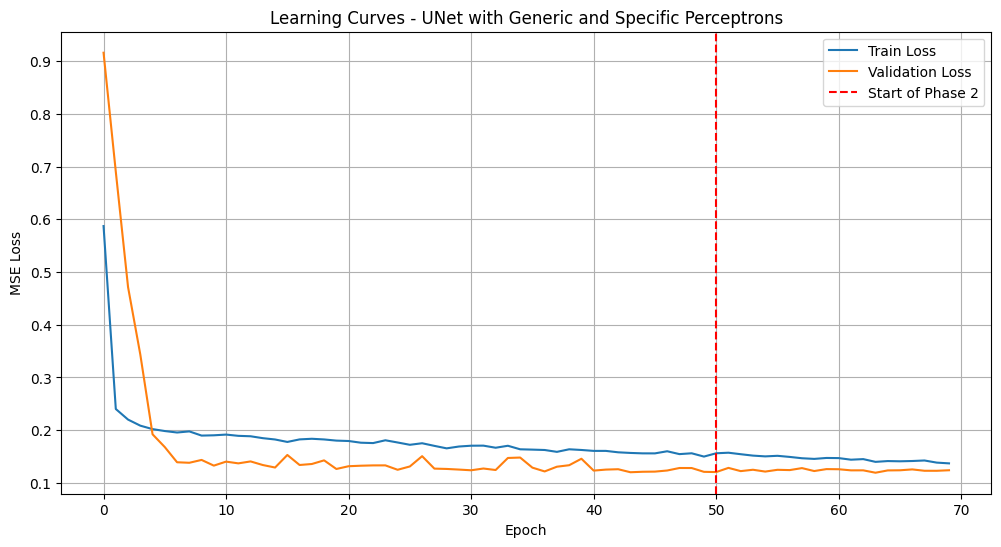

In [104]:
def train_with_generic_perceptron(model, trainloader, valloader, n_epochs_phase1=50, n_epochs_phase2=20, device='cuda'):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    margin = 120

    train_losses = []
    val_losses = []

    # Phase 1: Entraînement avec perceptron générique
    for epoch in range(n_epochs_phase1):
        # Training
        model.train()
        epoch_loss = 0.0
        batch_count = 0

        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
            optimizer.zero_grad()

            # Remplacer 25% des ids par l'index du perceptron générique
            modified_ids = ids.clone()
            mask = torch.rand(ids.shape) < 0.25
            modified_ids[mask] = model.generic_perceptron_idx

            modified_ids = modified_ids.to(device)
            attenuations = attenuations.unsqueeze(1).to(device)
            rain_rates = rain_rates.to(device)

            outputs = model(attenuations, modified_ids)
            loss = criterion(outputs[:, margin:-margin], rain_rates[:, margin:-margin])

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        train_losses.append(epoch_loss / batch_count)

        # Validation sur valloader uniquement
        model.eval()
        val_loss = 0.0
        val_count = 0

        with torch.no_grad():
            for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
                # Utiliser le perceptron générique pour la validation
                generic_ids = torch.full_like(ids, model.generic_perceptron_idx)
                generic_ids = generic_ids.to(device)
                attenuations = attenuations.unsqueeze(1).to(device)
                rain_rates = rain_rates.to(device)

                outputs = model(attenuations, generic_ids)
                loss = criterion(outputs[:, margin:-margin], rain_rates[:, margin:-margin])
                val_loss += loss.item()
                val_count += 1

        val_losses.append(val_loss / val_count)

        print(f'Phase 1 - Epoch {epoch+1}/{n_epochs_phase1}:')
        print(f'Train Loss: {train_losses[-1]:.6f}')
        print(f'Val Loss: {val_losses[-1]:.6f}')

    # Phase 2: Gel des poids et entraînement spécifique
    model.freeze_generic_parts()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

    for epoch in range(n_epochs_phase2):
        model.train()
        epoch_loss = 0.0
        batch_count = 0

        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
            optimizer.zero_grad()

            ids = ids.to(device)
            attenuations = attenuations.unsqueeze(1).to(device)
            rain_rates = rain_rates.to(device)

            outputs = model(attenuations, ids)
            loss = criterion(outputs[:, margin:-margin], rain_rates[:, margin:-margin])

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        train_losses.append(epoch_loss / batch_count)

        # Validation
        model.eval()
        val_loss = 0.0
        val_count = 0

        with torch.no_grad():
            for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
                generic_ids = torch.full_like(ids, model.generic_perceptron_idx)
                generic_ids = generic_ids.to(device)
                attenuations = attenuations.unsqueeze(1).to(device)
                rain_rates = rain_rates.to(device)

                outputs = model(attenuations, generic_ids)
                loss = criterion(outputs[:, margin:-margin], rain_rates[:, margin:-margin])
                val_loss += loss.item()
                val_count += 1

        val_losses.append(val_loss / val_count)

        print(f'Phase 2 - Epoch {epoch+1}/{n_epochs_phase2}:')
        print(f'Train Loss: {train_losses[-1]:.6f}')
        print(f'Val Loss: {val_losses[-1]:.6f}')

    return train_losses, val_losses

# Entraînement et visualisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet1DWithGenericPerceptron(n_channels=1).to(device)

train_losses, val_losses = train_with_generic_perceptron(model, trainloader, valloader)

# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(x=50, color='r', linestyle='--', label='Start of Phase 2')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curves - UNet with Generic and Specific Perceptrons')
plt.legend()
plt.grid(True)
plt.show()